In [408]:
import matplotlib.pyplot as plt
from numpy.random import default_rng
import numpy as np
import torch

from utils import split_data, train,  energy_lj, get_forces, MLP
import torch.nn.functional as F
from torch import nn
from torch.utils.data import  DataLoader
from IPython.display import clear_output
import numpy as np
from utils import radial_distribution_function
from torch.utils.data import Dataset, DataLoader, random_split

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## MD step function

In [5]:
rng = default_rng(23)


def langevin_step(
    r: torch.tensor,
    v: torch.tensor,
    f: torch.tensor,
    energy_fn: callable,
    dt: float,
    lc: float
):
    """Langevin step: MD in NVT ensemble.

    Parameters
    ----------
    r: positions

    v: velocities

    f: forces

    dt: time step

    lc: Parameters Langevin dynamics

    energy_fn: energy function

    Return
    ------
    r: updated position

    v: updated velocities

    f: updated forces


    """
    com = torch.mean(v, axis=0)
    v -= com

    # langevin thermo, 1st half step
    v = lc[0] * v + lc[1] * torch.normal(mean=0., std=1., size=(v.shape))

    # Verlet part of MD step
    v = v + 0.5 * f * dt

    # update positions
    r = r + v * dt

    f = get_forces(energy_fn, r)

    v = v + 0.5 * f * dt

    # langevin thermo, 2nd half step
    v = lc[0] * v + lc[1] * torch.normal(mean=0., std=1.,size=(v.shape))

    return r, v, f

## Run MD

In [6]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)

# 3d cluster
clus3d_without_0 = torch.tensor(
    [
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)

# Refence energy: tensor(-9.1530)

In [7]:
def assign_MBv(n_particles, beta, m: float = 1.0):
    """Assign Maxwell-Boltzmann distributed velocities.

    Parameters
    ----------
    v: velocity array

    beta: 1/ (kB * T)

    m: atomic mass


    Return
    ------
    v:     velocity array

    """

    v = torch.normal(mean=0, std=np.sqrt(1.0 / (beta * m)), size=(n_particles, 3))

    return v

In [8]:
# compute LJ energy
energy1 = energy_lj(clus3d)
energy2 = energy1
energy3 = energy_lj(clus3d_without_0)

# set Boltzmann constant
beta = 40.
m = 1.0

beta1 = 40.
beta2 = 4.
beta3 = 4.

dt =1e-3



In [9]:
r = torch.clone(clus3d)
n_particles = len(r)
n_dimensions = r.shape[-1]

r1 = torch.clone(clus3d)
r2 = torch.clone(clus3d)
r3 = torch.clone(clus3d_without_0)

n_particles1 = len(r1)
n_dimensions1 = r1.shape[-1]
n_particles2 = len(r2)
n_dimensions2 = r2.shape[-1]
n_particles3 = len(r3)
n_dimensions3 = r3.shape[-1]

In [10]:

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

v1 = assign_MBv(n_particles1, beta1, m)
v2 = assign_MBv(n_particles2, beta2, m)
v3 = assign_MBv(n_particles3, beta3, m)

# compute initial forces
f = get_forces(energy_lj, r)

f1 = get_forces(energy_lj, r1)
f2 = get_forces(energy_lj, r2)
f3 = get_forces(energy_lj, r3)



In [11]:
# initialize number of MD steps
n_steps = int(10e5)

n_log = 50

# energies
potential_energies = torch.empty((n_steps // n_log,1))
positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))

potential_energies1 = torch.empty((n_steps // n_log,1))
positions1 = torch.empty((n_steps // n_log, n_particles1, n_dimensions1))

potential_energies2 = torch.empty((n_steps // n_log,1))
positions2 = torch.empty((n_steps // n_log, n_particles2, n_dimensions2))

potential_energies3 = torch.empty((n_steps // n_log,1))
positions3 = torch.empty((n_steps // n_log, n_particles3, n_dimensions3))

In [12]:
# initialize langevin parameters
lgamma = torch.tensor(1.0)
c1 = torch.exp(-lgamma*dt/2.0)
c2 = torch.sqrt((1.0-(c1*c1))/beta)
lc = torch.tensor([c1,c2])

# initialize langevin parameters
lgamma_1 = torch.tensor(1.0)
c1_1 = torch.exp(-lgamma_1*dt/2.0)
c2_1 = torch.sqrt((1.0-(c1_1*c1_1))/beta1)
lc_1 = torch.tensor([c1_1,c2_1])

# initialize langevin parameters
lgamma_1 = torch.tensor(1.0)
c1_1 = torch.exp(-lgamma_1*dt/2.0)
c2_1 = torch.sqrt((1.0-(c1_1*c1_1))/beta1)
lc_1 = torch.tensor([c1_1,c2_1])

# initialize langevin parameters
lgamma_2 = torch.tensor(1.0)
c1_2 = torch.exp(-lgamma_2*dt/2.0)
c2_2 = torch.sqrt((1.0-(c1_2*c1_2))/beta2)
lc_2 = torch.tensor([c1_2,c2_2])

# initialize langevin parameters
lgamma_3 = torch.tensor(1.0)
c1_3 = torch.exp(-lgamma_3*dt/2.0)
c2_3 = torch.sqrt((1.0-(c1_3*c1_3))/beta3)
lc_3 = torch.tensor([c1_3,c2_3])

In [70]:
# # run Langevin
# for i in range(n_steps):
#     if i % n_log == 0:
#         positions[i // n_log] = r
#         potential_energies[i// n_log] = energy_lj(r)
#     r, v, f = langevin_step(r, v, f,energy_lj, dt, lc)

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions1[i // n_log] = r1
        potential_energies1[i// n_log] = energy_lj(r1)
    r1, v1, f1 = langevin_step(r1, v1, f1, energy_lj, dt, lc_1)

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions2[i // n_log] = r2
        potential_energies2[i// n_log] = energy_lj(r2)
    r2, v2, f2 = langevin_step(r2, v2, f2, energy_lj, dt, lc_2)

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions3[i // n_log] = r3
        potential_energies3[i// n_log] = energy_lj(r3)
    r3, v3, f3 = langevin_step(r3, v3, f3, energy_lj, dt, lc_3)


In [281]:
# torch.save(potential_energies1, "potential_energies1")
# torch.save(potential_energies2, "potential_energies2")
# torch.save(potential_energies3, "potential_energies3")

# torch.save(positions1, "positions1")
# torch.save(positions2, "positions2")
# torch.save(positions3, "positions3")

potential_energies1 = torch.load('potential_energies1')
potential_energies2 = torch.load('potential_energies2')
potential_energies3 = torch.load('potential_energies3')

positions1 = torch.load('positions1')
positions2 = torch.load('positions2')
positions3 = torch.load('positions3')




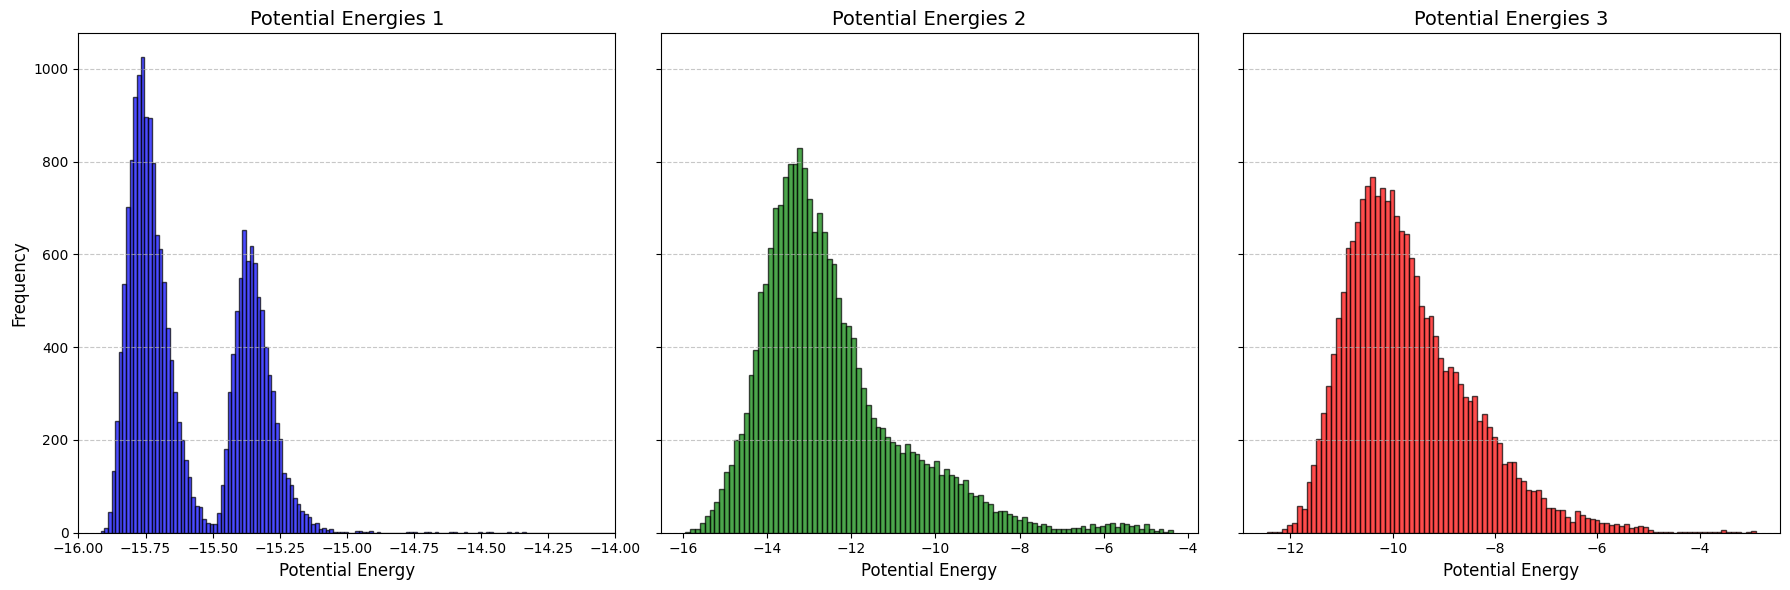

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each dataset in a separate subplot
axes[0].hist(potential_energies1, bins=500, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Potential Energies 1', fontsize=14)
axes[0].set_xlabel('Potential Energy', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xlim(-16, -14)

axes[1].hist(potential_energies2, bins=100, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Potential Energies 2', fontsize=14)
axes[1].set_xlabel('Potential Energy', fontsize=12)

axes[2].hist(potential_energies3, bins=100, color='red', alpha=0.7, edgecolor='black')
axes[2].set_title('Potential Energies 3', fontsize=14)
axes[2].set_xlabel('Potential Energy', fontsize=12)

# Add grid to all subplots
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

Here are the potential energy plots of the three simulations (numbered in order they are presented in the assignment). Low energy states (simulation # 1) leads to a bimodal energy distribution, while high energy gives a more uniform boltzman-looking distribution (we could try fitting a boltzman distribution to test this vs. other curve models but I didn't have time to do this)

In [282]:
rdf1 = radial_distribution_function(positions1.detach().numpy())
rdf2 = radial_distribution_function(positions2.detach().numpy())
rdf3 = radial_distribution_function(positions3.detach().numpy())

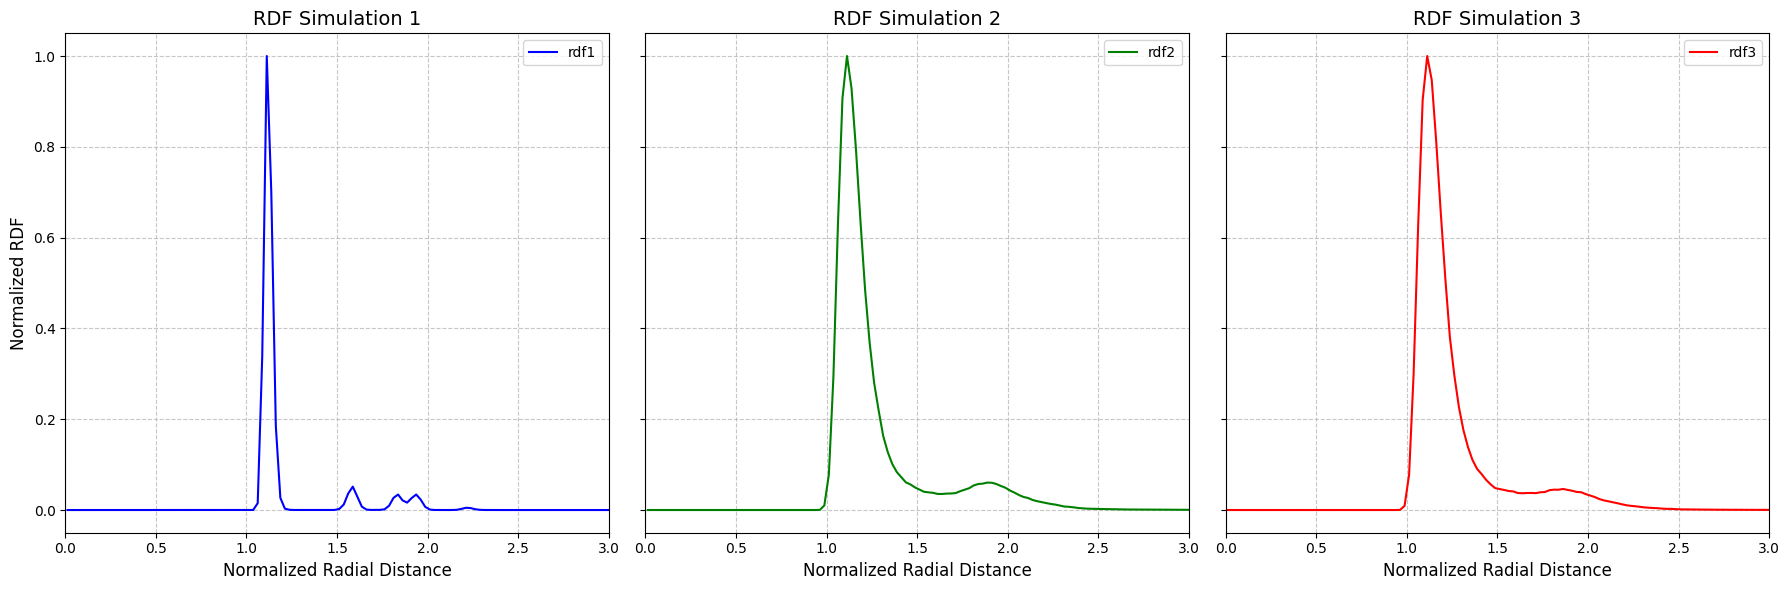

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot rdf1
axes[0].plot(rdf1[0], rdf1[1] / rdf1[1].max(), label='rdf1', color='blue')
axes[0].set_title('RDF Simulation 1', fontsize=14)
axes[0].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[0].set_ylabel('Normalized RDF', fontsize=12)
axes[0].legend()

# Plot rdf2
axes[1].plot(rdf2[0], rdf2[1] / rdf2[1].max(), label='rdf2', color='green')
axes[1].set_title('RDF Simulation 2', fontsize=14)
axes[1].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[1].legend()

# Plot rdf3
axes[2].plot(rdf3[0], rdf3[1] / rdf3[1].max(), label='rdf3', color='red')
axes[2].set_title('RDF Simulation 3', fontsize=14)
axes[2].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[2].legend()

axes[0].set_xlim(0,3)
axes[1].set_xlim(0,3)
axes[2].set_xlim(0,3)

# Add grid to all subplots
for ax in axes:
    ax.grid(linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

# plt.plot(rdf[0], rdf[1] / rdf[1].max())


Low energy simulations has more discrete bumps, which is consistent with our previous observation that it has more discrete energy states instead of a single uniform one.

## Behler-Parinello symmetry functions

In [284]:
def f_c(distance, r_cut):
    return torch.where(distance <= r_cut, 0.5 * (torch.cos(np.pi * distance / r_cut) + 1), 0)

"Bare" Behler-Parrinello functions, these functions do not involve a sum over neighboring atoms.

In [289]:
def g_1_func(distances, r_cut):
    return f_c(distances, r_cut)

def g_2_func(distances, eta, r_cut):
    return torch.exp(-eta*distances**2) * f_c(distances, r_cut)

def g_3_func(distances, kappa, r_cut):
    return torch.cos(kappa * distances) * f_c(distances, r_cut)

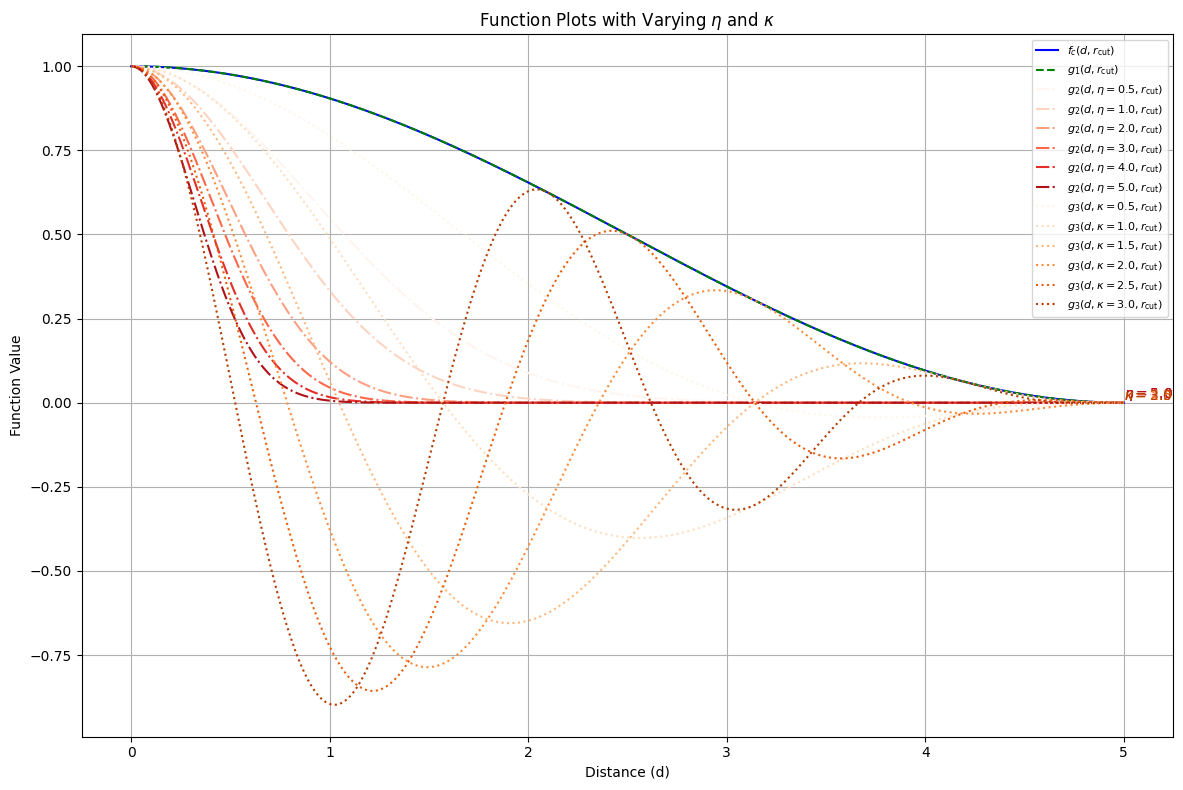

In [ ]:
def f_c(distance, r_cut):
    return torch.where(distance <= r_cut, 0.5 * (torch.cos(np.pi * distance / r_cut) + 1), torch.tensor(0.0))

def g_1_func(distances, r_cut):
    return f_c(distances, r_cut)

def g_2_func(distances, eta, r_cut):
    return torch.exp(-eta * distances**2) * f_c(distances, r_cut)

def g_3_func(distances, kappa, r_cut):
    return torch.cos(kappa * distances) * f_c(distances, r_cut)

r_cut = 5.0 
eta_values = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]  
kappa_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]  
distances = torch.linspace(0, r_cut, 500)  

f_values = f_c(distances, r_cut)
g1_values = g_1_func(distances, r_cut)

f_values_np = f_values.numpy()
g1_values_np = g1_values.numpy()

g2_cmap = plt.cm.Reds 
g3_cmap = plt.cm.Oranges  

plt.figure(figsize=(12, 8))

plt.plot(distances.numpy(), f_values_np, label=r"$f_c(d, r_{\text{cut}})$", linestyle='-', color='blue')
plt.plot(distances.numpy(), g1_values_np, label=r"$g_1(d, r_{\text{cut}})$", linestyle='--', color='green')

for i, eta in enumerate(eta_values):
    label = r"$g_2(d, \eta = %.1f, r_{\text{cut}})$" % eta
    g2_values = g_2_func(distances, eta, r_cut)
    color = g2_cmap(i / len(eta_values)) 
    line, = plt.plot(distances.numpy(), g2_values.numpy(), label=label, linestyle='-.', color=color)
    
    plt.text(distances[-1].item(), g2_values[-1].item(), f"$\\eta={eta}$", color=color, fontsize=10, verticalalignment='bottom')

for i, kappa in enumerate(kappa_values):
    label = r"$g_3(d, \kappa = %.1f, r_{\text{cut}})$" % kappa
    g3_values = g_3_func(distances, kappa, r_cut)
    color = g3_cmap(i / len(kappa_values)) 
    line, = plt.plot(distances.numpy(), g3_values.numpy(), label=label, linestyle=':', color=color)
    
    plt.text(distances[-1].item(), g3_values[-1].item(), f"$\\kappa={kappa}$", color=color, fontsize=10, verticalalignment='bottom')

plt.title(r"Function Plots with Varying $\eta$ and $\kappa$")
plt.xlabel("Distance (d)")
plt.ylabel("Function Value")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.show()


Here it looks like eta and kappa are metrics of "eccentricity" of the funcitons - how much they curve and how much they deviate from the baseline function. 

In [287]:
etas = np.geomspace(0.01, 5.0, 10)
kappas = np.linspace(0.5, 5.0, 10)

torch.Size([2000, 7, 7])

In [ ]:
# positions2_sample[100]

tensor([[ 0.1616,  0.6677,  0.1475],
        [ 0.1743,  0.2063, -0.9190],
        [ 0.8888, -0.1674, -0.0806],
        [-0.5069, -0.1936, -0.1256],
        [-0.0735, -0.1349,  0.9421],
        [ 0.2472, -0.9481, -0.4399],
        [-0.9276,  0.5965,  0.5299]])

Behler-Parrinello symmetry defined as sum over all neighbors

In [290]:
# Distances refer to the distance array
# of the particle under consideration to all other particles
def g_1_feature(distances, r_cut):
    return torch.sum(g_1_func(distances, r_cut))

def g_2_feature(distances, eta, r_cut):
    return torch.sum(g_2_func(distances, eta, r_cut))

def g_3_feature(distances, kappa, r_cut):
    return torch.sum(g_3_func(distances, kappa, r_cut))

In [104]:
distances2_sample.shape

torch.Size([2000, 7, 7])

In [294]:
G1_feature = torch.tensor([g_1_feature(d, r_cut) for d in distances2_sample])# feature1
features = [G1_feature]

for eta in etas:
  features.append(torch.tensor([g_2_feature(d, eta, r_cut) for d in distances2_sample]))
for kappa in kappas:
  features.append(torch.tensor([g_3_feature(d, kappa, r_cut) for d in distances2_sample]))


In [102]:
features[0].shape
len(features)

21

In [292]:
# Feature computation
def compute_features(distances, etas, kappas, r_cut):
    """
    Compute G1, G2 (for all eta), and G3 (for all kappa) features
    and return a tensor of shape (n_samples, n_particles, n_features).
    """
    n_samples, n_particles, _ = distances.shape  # Unpack dimensions
    
    # Total number of features: G1 (1) + G2 (len(etas)) + G3 (len(kappas))
    n_features = 1 + len(etas) + len(kappas)
    features = torch.zeros((n_samples, n_particles, n_features))
    
    # Compute G1 feature
    g1 = g_1_func(distances, r_cut)
    features[:, :, 0] = torch.sum(g1, dim=2)
    
    # Compute G2 features
    for i, eta in enumerate(etas):
        g2 = g_2_func(distances, eta, r_cut)
        features[:, :, 1 + i] = torch.sum(g2, dim=2)
    
    # Compute G3 features
    for j, kappa in enumerate(kappas):
        g3 = g_3_func(distances, kappa, r_cut)
        features[:, :, 1 + len(etas) + j] = torch.sum(g3, dim=2)
    
    return features

In [399]:
n_samples2 = 2000
idx2 = torch.randperm(positions2.shape[0])[:n_samples2]
positions2_sample = positions2[idx2]
distances2_sample = torch.cdist(positions2_sample, positions2_sample, p=2)
distances2_sample.shape


# n_samples2 = 20000  
# idx2 = torch.randperm(positions2.shape[0])[:n_samples2]
# positions2_sample = positions2[idx2]
# train_fraction = 0.8
# n_train = int(train_fraction * n_samples2)

# positions2_train = positions2_sample[:n_train]
# positions2_test = positions2_sample[n_train:]

# # Compute pairwise distances for train and test sets
# distances2_train = torch.cdist(positions2_train, positions2_train, p=2)
# distances2_test = torch.cdist(positions2_test, positions2_test, p=2)

torch.Size([2000, 7, 7])

In [ ]:


# # Random positions for particles
# positions2 = torch.rand((n_particles * n_samples2, 3))
# idx2 = torch.randint(0, positions2.shape[0], (n_samples2,))
positions2_sample = positions2[idx2]
potential_energies2_sample = potential_energies2[idx2]

# Compute pairwise distances
distances2_sample = torch.cdist(positions2_sample, positions2_sample, p=2)  # Shape: (n_samples * n_particles, n_particles)

# Reshape to add the batch dimension
# distances2_sample = distances2_sample.view(n_samples2, n_particles, n_particles)

# DEBUG: Verify reshaped distances
print("Reshaped distances2_sample shape:", distances2_sample.shape)
features = compute_features(distances2_sample, etas, kappas, r_cut)
print("Feature tensor shape:", features.shape)  # Expected: (n_samples, n_particles, n_features)
print("Example features (first 5 simulation steps):")
print(features[:5, :, :])



Reshaped distances2_sample shape: torch.Size([2000, 7, 7])
Feature tensor shape: torch.Size([2000, 7, 21])
Example features (first 5 simulation steps):
tensor([[[ 6.0310,  5.9477,  5.8666,  5.7098,  5.4156,  4.8940,  4.0606,
           2.9444,  1.8262,  1.1572,  1.0060,  5.0246,  2.5043, -0.3504,
          -2.3877, -3.0606, -2.5028, -1.1700,  0.5530,  2.4319,  4.1656],
         [ 6.0582,  5.9761,  5.8959,  5.7407,  5.4481,  4.9261,  4.0844,
           2.9506,  1.8239,  1.1596,  1.0067,  5.0629,  2.5390, -0.3871,
          -2.5312, -3.2198, -2.4903, -0.8763,  0.9941,  2.6749,  3.9132],
         [ 6.2481,  6.1790,  6.1112,  5.9786,  5.7243,  5.2554,  4.4556,
           3.2836,  2.0037,  1.1978,  1.0082,  5.4025,  3.1404,  0.1957,
          -2.4780, -4.0195, -3.9388, -2.2746,  0.4228,  3.2751,  5.3640],
         [ 5.4637,  5.3454,  5.2317,  5.0161,  4.6267,  3.9857,  3.0920,
           2.1353,  1.4113,  1.0680,  1.0024,  4.0641,  0.9649, -1.5311,
          -1.9361, -0.6843,  0.6302,  0.96

In [238]:
class Data(Dataset):
    """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""

    def __init__(self, x: np.ndarray, y: np.ndarray, device):
        # self.x = torch.from_numpy(x).float().to(device)
        # self.y = torch.from_numpy(y).float().to(device)

        self.x = x
        self.y = y
        self.len = self.x.shape[0]

    def __getitem__(self, index: int) -> tuple:
        return self.x[index], self.y[index]

    def __len__(self) -> int:
        return self.len

In [ ]:
train_fraction = 0.8
batch_size = 32

dataset = Data(features, potential_energies2_sample, device=DEVICE)

train_size = int(train_fraction * len(dataset)) 
test_size = len(dataset) - train_size 

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [147]:
potential_energies2_sample.shape

torch.Size([2000, 1])

In [143]:
features.shape

torch.Size([2000, 7, 21])

In [240]:
class Modified_MLP(nn.Module):
    def __init__(self, n_units: list, activation=nn.ReLU()):
        """
        Simple multi-layer perceptron (MLP).

        Parameters:
        -----------
        n_units : List of integers specifying the dimensions of input and output and the hidden layers.
        activation: Activation function used for non-linearity.

        Example:
        -----------

        dim_hidden = 100
        dim_in = 2
        dim_out = 5

        # MLP with input dimension 2, output dimension 5, and 4 hidden layers of dimension 100
        model = MLP([dim_in,
                    dim_hidden,
                    dim_hidden,
                    dim_hidden,
                    dim_hidden,
                    dim_out],activation=nn.ReLU()).to(DEVICE)

        """
        super().__init__()

        # Get input and output dimensions
        dims_in = n_units[:-1]
        dims_out = n_units[1:]

        layers = []

        # Add linear layers (and activation function after all layers except the final one)
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            layers.append(torch.nn.Linear(dim_in, dim_out))

            if i < len(n_units) - 2:
                layers.append(activation)

        self._layers = torch.nn.Sequential(*layers)

    # def forward(self, values):
    #     rtn = 0
    #     for x in values: 
    #       rtn += self._layers(x)
    #     return rtn

    # def forward(self, values):
    #   # Initialize an empty tensor to store the summed outputs
    #   summed_outputs = torch.zeros(values.size(0), 1).to(DEVICE)
      
    #   # Loop over the batch
    #   for i in range(values.size(0)):
    #       for x in values[i]:
    #           summed_outputs[i] += self._layers(x)
      
    #   return summed_outputs

    def forward(self, values):
      # Apply layers to each row at once
      outputs = self._layers(values.view(-1, values.size(2)))
      
      # Sum the outputs for each batch item
      summed_outputs = outputs.view(values.size(0), 7).sum(dim=1, keepdim=True)
      
      return summed_outputs

    

    def count_parameters(self):
        """
        Counts the number of trainable parameters.

        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
def train(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.modules.loss._Loss,
    device,
):
    """
    Basic training loop for a pytorch model.

    Parameters:
    -----------
    model : pytorch model.
    train_loader : pytorch Dataloader containing the training data.
    optimizer: Optimizer for gradient descent.
    criterion: Loss function.

    Example usage:
    -----------

    model = (...) # a pytorch model
    criterion = (...) # a pytorch loss
    optimizer = (...) # a pytorch optimizer
    trainloader = (...) # a pytorch DataLoader containing the training data

    epochs = 10000
    log_interval = 1000
    for epoch in range(1, epochs + 1):
        loss_train = train(model, trainloader,optimizer, criterion)

        if epoch % log_interval == 0:
            print(f'Train Epoch: {epoch} Loss: {loss_train:.6f}')
        losses_train.append(loss_train)


    """
    # Set model to training mode
    model.train()
    epoch_loss = 0
    n_batches = len(train_loader)

    # Loop over each batch from the training set
    for data, target in train_loader:
        # Copy data to device
        data = data.to(device)
        target = target.to(device)

        # set optimizer to zero grad to remove previous gradients
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        # print("outpu and target: ")
        # print(output, target)
        loss = criterion(output, target)

        # get gradients
        loss.backward()

        # gradient descent
        optimizer.step()

        epoch_loss += loss.data.item()

    return epoch_loss / n_batches

Inspecting batch sizes...

Batch 1:
  Features shape: torch.Size([32, 7, 21])
  Targets shape: torch.Size([32, 1])
Batch 2:
  Features shape: torch.Size([32, 7, 21])
  Targets shape: torch.Size([32, 1])
Batch 3:
  Features shape: torch.Size([32, 7, 21])
  Targets shape: torch.Size([32, 1])


In [ ]:
architecture = [21] + [25, 25, 25] + [1]
# print(architecture)
model = Modified_MLP(architecture).to(DEVICE)
coords = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
train_losses = []
test_losses = []
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Adjust `step_size` and `gamma` as needed

In [191]:
for i, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

    # Check the shape of inputs and targets
    print(f"Batch {i+1}:")
    print(f"  Inputs shape: {inputs.shape}")
    print(f"  Targets shape: {targets.shape}")

    # Reshape inputs if necessary
    # inputs = inputs.view(-1, inputs.size(1))  # Ensure [num_rows, num_features]
    
    # Apply model
    outputs = model(inputs)

    print(f"  Outputs shape: {outputs.shape}")

    # Reshape targets if necessary
    # targets = targets.view(-1, 1)  # Ensure [num_rows, 1]

    # Compute loss
    loss = criterion(outputs, targets)
    
    print(f"  Outputs shape: {outputs.shape}")
    print(f"  Loss: {loss.item()}")

    # Break after checking the first batch for simplicity
    break



Batch 1:
  Inputs shape: torch.Size([32, 7, 21])
  Targets shape: torch.Size([32, 1])
  Outputs shape: torch.Size([32, 1])
  Outputs shape: torch.Size([32, 1])
  Loss: 151.808837890625


In [192]:
# Assuming 'model' is your PyTorch model and 'data_loader' is your DataLoader
for i, (inputs, targets) in enumerate(train_loader):
    # Move inputs and targets to the device (GPU/CPU)
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    
    # Check the shape of inputs and targets
    print(f"Batch {i+1}:")
    print(f"  Inputs shape: {inputs.shape}")
    print(f"  Targets shape: {targets.shape}")

    # Apply the model
    outputs = model(inputs)

    # Check the shape of the model's output
    print(f"  Outputs shape: {outputs.shape}")

    # Calculate the loss
    loss = criterion(outputs, targets)
    print(f"  Loss: {loss.item()}")

    # Break after checking the first batch for simplicity
    break


Batch 1:
  Inputs shape: torch.Size([32, 7, 21])
  Targets shape: torch.Size([32, 1])
  Outputs shape: torch.Size([32, 1])
  Loss: 151.61863708496094


In [405]:
EPOCHS = 20000
eval_period = 10

epochs_per_loss_record = 1

for epoch in range(EPOCHS):
    # print("epoch: ", epoch)
    train_losses.append(train(model, train_loader, optimizer, criterion, DEVICE))
    model.eval()
    test_loss = 0
    if epoch % eval_period == 0:
      with torch.no_grad():
          for inputs, targets in test_loader:
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              test_loss += loss.item()
          test_loss /= len(test_loader)
          test_losses.append(test_loss)
          print(f"Epoch: {epoch} | Train Loss: {train_losses[-1]} Test Loss: {test_losses[-1]}")
    scheduler.step()
torch.save(model.state_dict(), "model_weights_hw09.pth")

Epoch: 0 | Train Loss: 0.03289192739874124 Test Loss: 0.03562205098569393
Epoch: 10 | Train Loss: 0.03583133652806282 Test Loss: 0.03920474275946617
Epoch: 20 | Train Loss: 0.032781981863081455 Test Loss: 0.03938041512782757
Epoch: 30 | Train Loss: 0.03601448291912675 Test Loss: 0.036885748259150065
Epoch: 40 | Train Loss: 0.028825473822653293 Test Loss: 0.04508450856575599
Epoch: 50 | Train Loss: 0.041802614107728 Test Loss: 0.04998028092086315
Epoch: 60 | Train Loss: 0.04192470818758011 Test Loss: 0.05614111744440519
Epoch: 70 | Train Loss: 0.03419331181794405 Test Loss: 0.03750349824818281
Epoch: 80 | Train Loss: 0.036839517429471016 Test Loss: 0.04467038652644707
Epoch: 90 | Train Loss: 0.04052678972482681 Test Loss: 0.04277064550954562
Epoch: 100 | Train Loss: 0.056596632171422245 Test Loss: 0.0504203625023365
Epoch: 110 | Train Loss: 0.029139224793761968 Test Loss: 0.03511451585934712
Epoch: 120 | Train Loss: 0.029817824233323336 Test Loss: 0.036807660586558856
Epoch: 130 | Train

KeyboardInterrupt: 

The test loss started lower than the train loss, and overall the model didn't reach lower than 0.02 train error and 0.042 test error. This makes me thing something is wrong, but I couldn't figure out what. I tried refreshing my data, retraining, adjusting the learning rate, but to no avail. I suspect there could be a computational error in how I'm computing the loss, or how I defined my MLP, but I couldn't find it. Classmates I talked to didn't modify the forward function, and got different results, so that could be related. Despite that, the model is still ok, and reasonably fits the data, as shown in the next plot, so subsequent results are still reasonable even if lower quality than I would have liked. 

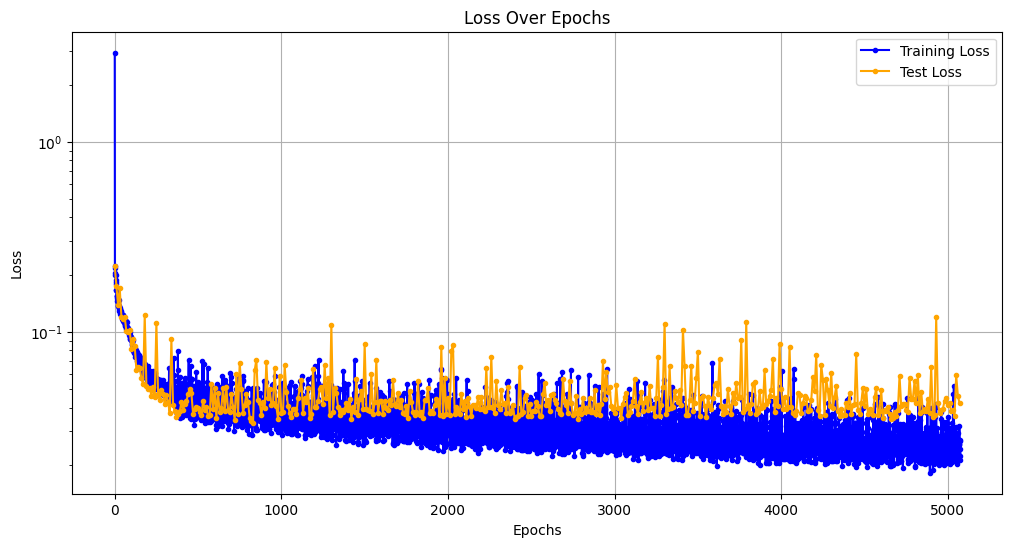

In [406]:

# Create an array of epochs for the training losses
epochs_arr = list(range(len(train_losses)))

# Calculate the indices for `test_epochs` based on `eval_period`
test_epochs = list(range(0, len(train_losses), eval_period))

min_length = min(len(test_epochs), len(test_losses))
test_epochs = test_epochs[:min_length]
test_losses = test_losses[:min_length]

# if len(test_epochs) != len(test_losses):
#   test_epochs = test_epochs[:len(test_losses) + 1]

plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(epochs_arr, train_losses, marker='.', linestyle='-', color='blue', label='Training Loss')

# Plot test loss at corresponding epochs (every eval_period-th epoch)
plt.plot(test_epochs, test_losses, marker='.', linestyle='-', color='orange', label='Test Loss')

# Title, labels, and legend
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')

# Grid for better readability
plt.grid(True)

# Show the plot
plt.show()




In [255]:
print(test_epochs)
print(len(test_losses))


[0, 10, 20, 30, 40, 50, 60, 70]
7


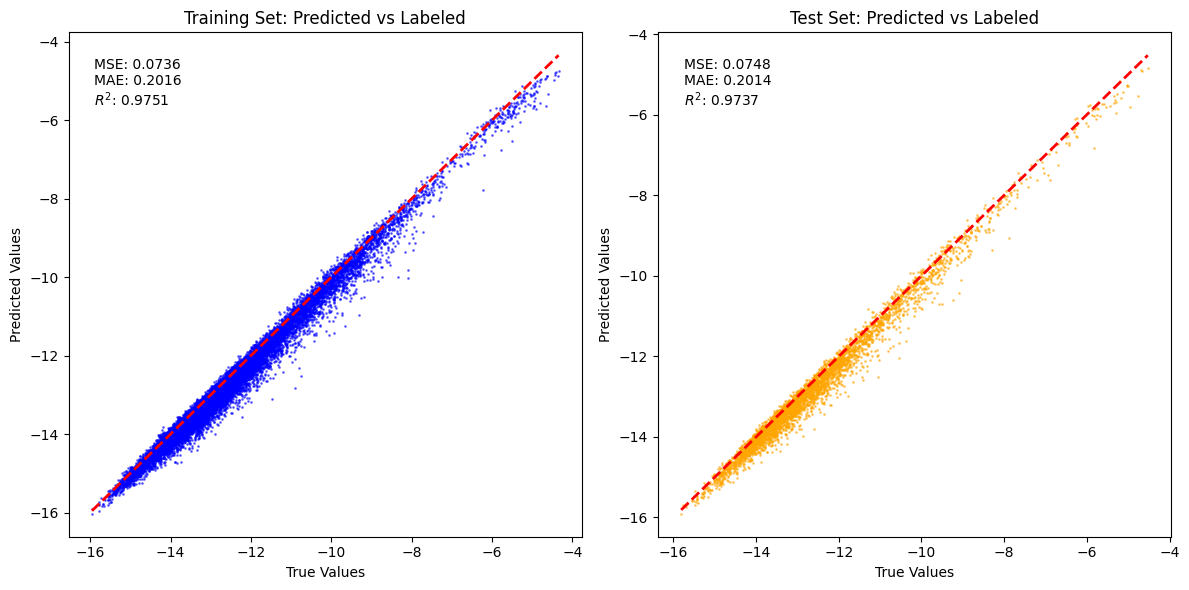

In [410]:
def calculate_metrics(true, predicted):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    return mse, mae, r2

# Metrics for training set
train_mse, train_mae, train_r2 = calculate_metrics(train_true, train_predictions)

# Metrics for test set
test_mse, test_mae, test_r2 = calculate_metrics(test_true, test_predictions)

# Plotting with metrics
plt.figure(figsize=(12, 6))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(train_true, train_predictions, color='blue', alpha=0.5, s=1)
plt.title('Training Set: Predicted vs Labeled')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(train_true), max(train_true)], [min(train_true), max(train_true)], 'r--', lw=2)  # Ideal line
# Add metrics text
plt.text(0.05, 0.95, f"MSE: {train_mse:.4f}\nMAE: {train_mae:.4f}\n$R^2$: {train_r2:.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Test set
plt.subplot(1, 2, 2)
plt.scatter(test_true, test_predictions, color='orange', alpha=0.5, s=1)
plt.title('Test Set: Predicted vs Labeled')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], 'r--', lw=2)  # Ideal line
# Add metrics text
plt.text(0.05, 0.95, f"MSE: {test_mse:.4f}\nMAE: {test_mae:.4f}\n$R^2$: {test_r2:.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()



In [378]:
def energy_model(r):
    distances = torch.cdist(r, r, p=2)
    # print(distances.shape)

    n_features = 1 + len(etas) + len(kappas)
    features = torch.zeros((n_particles, n_features))
    
    # Compute G1 feature
    g1 = g_1_func(distances, r_cut)
    features[:, 0] = torch.sum(g1, dim=1)
    
    # Compute G2 features
    for i, eta in enumerate(etas):
        g2 = g_2_func(distances, eta, r_cut)
        features[:, 1 + i] = torch.sum(g2, dim=1)
    
    # Compute G3 features
    for j, kappa in enumerate(kappas):
        g3 = g_3_func(distances, kappa, r_cut)
        features[:, 1 + len(etas) + j] = torch.sum(g3, dim=1)
    
    features = features.unsqueeze(0).to(DEVICE) 
    energies = model(features).squeeze(0)
    total_energy = energies.sum() 
    return total_energy


print(energy_model(clus3d))

tensor(-9.3541, grad_fn=<SumBackward0>)


In [379]:
mean_energy1 = potential_energies1.mean()
abs_diff1 = torch.abs(potential_energies1 - mean_energy1)
closest_index1 = torch.argmin(abs_diff1)

mean_energy2 = potential_energies2.mean()
abs_diff2 = torch.abs(potential_energies2 - mean_energy2)
closest_index2 = torch.argmin(abs_diff2)

mean_energy3 = potential_energies3.mean()
abs_diff3 = torch.abs(potential_energies3 - mean_energy3)
closest_index3 = torch.argmin(abs_diff3)

In [ ]:
energy4 = mean_energy1
energy5 = mean_energy2
energy6 = mean_energy3


beta4 = beta1
beta5 = beta2
beta6 = beta3
# m = 1.0
# dt =1e-3

r4 = torch.clone(positions2[closest_index1])
r5 = torch.clone(positions2[closest_index2])
r6 = torch.clone(positions2[closest_index3])

n_particles4 = len(r4)
n_dimensions4 = r4.shape[-1]
n_particles5 = len(r5)
n_dimensions5 = r5.shape[-1]
n_particles6 = len(r6)
n_dimensions6 = r6.shape[-1]

# assign intial MB velocities
v4 = assign_MBv(n_particles4, beta4, m)
v5 = assign_MBv(n_particles5, beta5, m)
v6 = assign_MBv(n_particles6, beta6, m)


# compute initial forces
f4 = get_forces(energy_model, r4)
f5 = get_forces(energy_model, r5)
f6 = get_forces(energy_model, r6)


# initialize number of MD steps
n_steps = int(10e4)

n_log = 50

# energies
potential_energies4 = torch.empty((n_steps // n_log,1))
positions4 = torch.empty((n_steps // n_log, n_particles4, n_dimensions4))
potential_energies5 = torch.empty((n_steps // n_log,1))
positions5 = torch.empty((n_steps // n_log, n_particles5, n_dimensions5))
potential_energies6 = torch.empty((n_steps // n_log,1))
positions6 = torch.empty((n_steps // n_log, n_particles6, n_dimensions6))


# initialize langevin parameters
lgamma_4 = torch.tensor(1.0)
c1_4 = torch.exp(-lgamma_4*dt/2.0)
c2_4 = torch.sqrt((1.0-(c1_4*c1_4))/beta4)
lc_4 = torch.tensor([c1_4,c2_4])

lgamma_5 = torch.tensor(1.0)
c1_5 = torch.exp(-lgamma_5*dt/2.0)
c2_5 = torch.sqrt((1.0-(c1_5*c1_5))/beta5)
lc_5 = torch.tensor([c1_5,c2_5])

lgamma_6 = torch.tensor(1.0)
c1_6 = torch.exp(-lgamma_6*dt/2.0)
c2_6 = torch.sqrt((1.0-(c1_6*c1_6))/beta6)
lc_6 = torch.tensor([c1_6,c2_6])

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions4[i // n_log] = r4
        potential_energies4[i// n_log] = energy_model(r4)
    r4, v4, f4 = langevin_step(r4, v4, f4, energy_model, dt, lc_4)

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions5[i // n_log] = r5
        potential_energies5[i// n_log] = energy_model(r5)
    r5, v5, f5 = langevin_step(r5, v5, f5, energy_model, dt, lc_5)

# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions6[i // n_log] = r6
        potential_energies6[i// n_log] = energy_model(r6)
    r6, v6, f6 = langevin_step(r6, v6, f6, energy_model, dt, lc_6)

In [415]:
# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions5[i // n_log] = r5
        potential_energies5[i// n_log] = energy_model(r5)
    r5, v5, f5 = langevin_step(r5, v5, f5, energy_model, dt, lc_5)


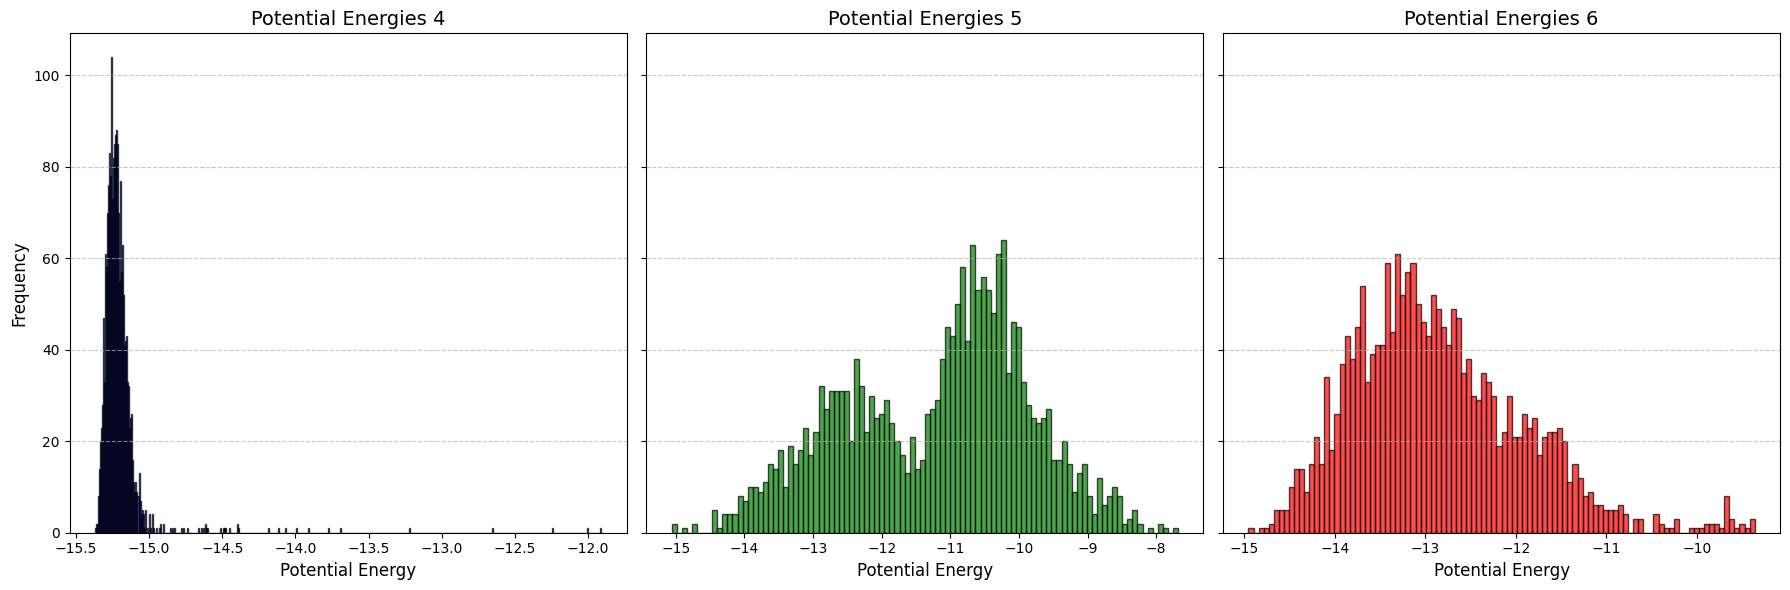

In [385]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each dataset in a separate subplot
axes[0].hist(potential_energies4.detach().numpy(), bins=500, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Potential Energies 4', fontsize=14)
axes[0].set_xlabel('Potential Energy', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
# axes[0].set_xlim(-16, -14)

axes[1].hist(potential_energies5.detach().numpy(), bins=100, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Potential Energies 5', fontsize=14)
axes[1].set_xlabel('Potential Energy', fontsize=12)

axes[2].hist(potential_energies6.detach().numpy(), bins=100, color='red', alpha=0.7, edgecolor='black')
axes[2].set_title('Potential Energies 6', fontsize=14)
axes[2].set_xlabel('Potential Energy', fontsize=12)

# Add grid to all subplots
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

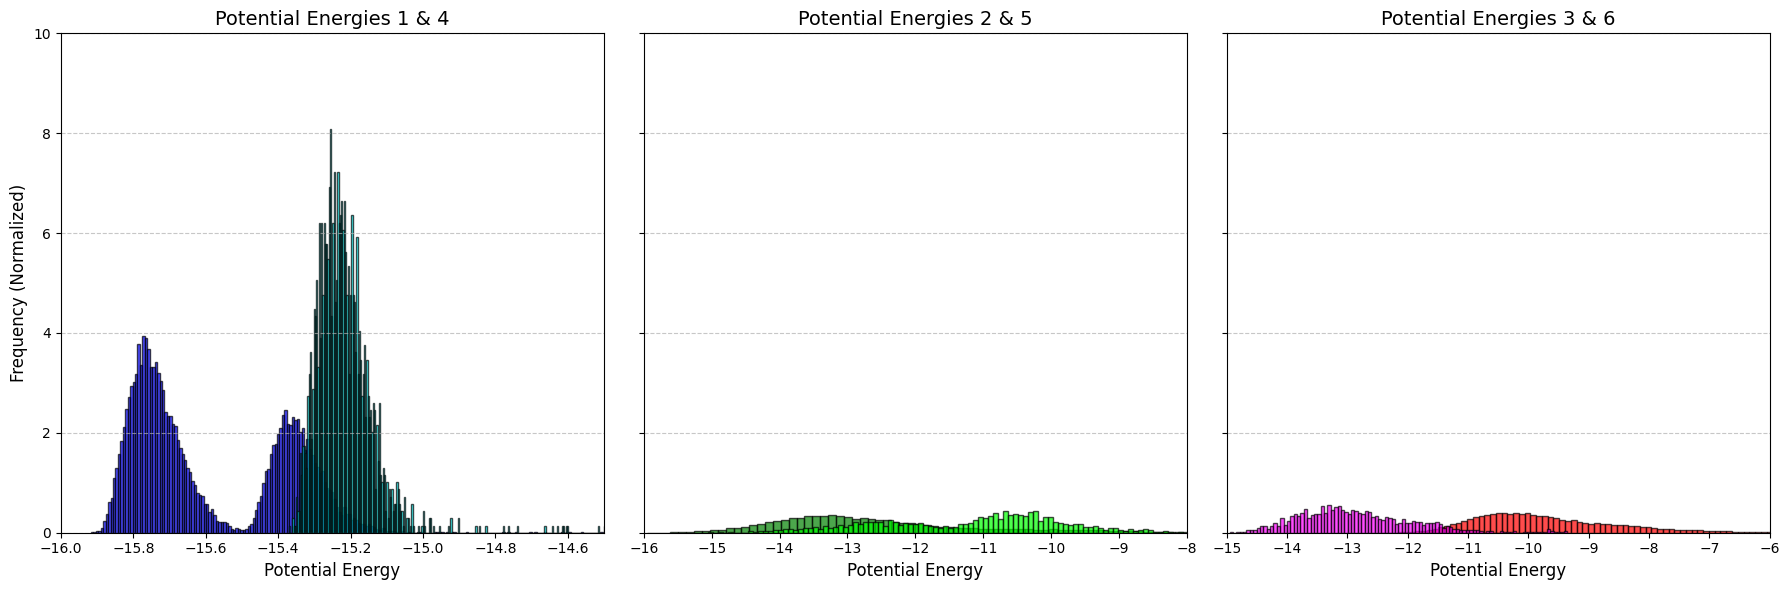

In [398]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each dataset in a separate subplot
axes[0].hist(potential_energies1.detach().numpy(), bins=1000, color='blue', alpha=0.7, edgecolor='black', label='Original 1', density=True)
axes[0].hist(potential_energies4.detach().numpy(), bins=1000, color='cyan', alpha=0.7, edgecolor='black', label='Modeled 4', density=True)
axes[0].set_title('Potential Energies 1 & 4', fontsize=14)
axes[0].set_xlabel('Potential Energy', fontsize=12)
axes[0].set_ylabel('Frequency (Normalized)', fontsize=12)
axes[0].set_xlim(-16, -14.5)

# Set individual y-limits for each plot based on data range
axes[0].set_ylim(0, max(axes[0].get_ylim()[1], 10))  # Set y limit automatically based on the data

axes[1].hist(potential_energies2.detach().numpy(), bins=100, color='green', alpha=0.7, edgecolor='black', label='Original 2', density=True)
axes[1].hist(potential_energies5.detach().numpy(), bins=100, color='lime', alpha=0.7, edgecolor='black', label='Modeled 5', density=True)
axes[1].set_title('Potential Energies 2 & 5', fontsize=14)
axes[1].set_xlabel('Potential Energy', fontsize=12)
axes[1].set_xlim(-16, -8)
axes[1].set_ylim(0, max(axes[1].get_ylim()[1], 0.6))  # Set y limit automatically based on the data

axes[2].hist(potential_energies3.detach().numpy(), bins=100, color='red', alpha=0.7, edgecolor='black', label='Original 3', density=True)
axes[2].hist(potential_energies6.detach().numpy(), bins=100, color='magenta', alpha=0.7, edgecolor='black', label='Modeled 6', density=True)
axes[2].set_title('Potential Energies 3 & 6', fontsize=14)
axes[2].set_xlabel('Potential Energy', fontsize=12)
axes[2].set_xlim(-15, -6)
axes[2].set_ylim(0, max(axes[2].get_ylim()[1], 0.6))  # Set y limit automatically based on the data

# Add grid to all subplots
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()




Simulations 4-6 correspond to 1-3 respectively, but with the model approximation. Given the accuracies of previous simulations, and the amount of training time and the error of the model, this doesn't look too bad. We're getting somewhat stable hills close to the expected values. I suspect more accuracy model would improve this substantially. I'd also like to see the two-peak behavior appear in simulation 4, and disappear in simulation 5. 

In [416]:
rdf4 = radial_distribution_function(positions4.detach().numpy())
rdf5 = radial_distribution_function(positions5.detach().numpy())
rdf6 = radial_distribution_function(positions6.detach().numpy())

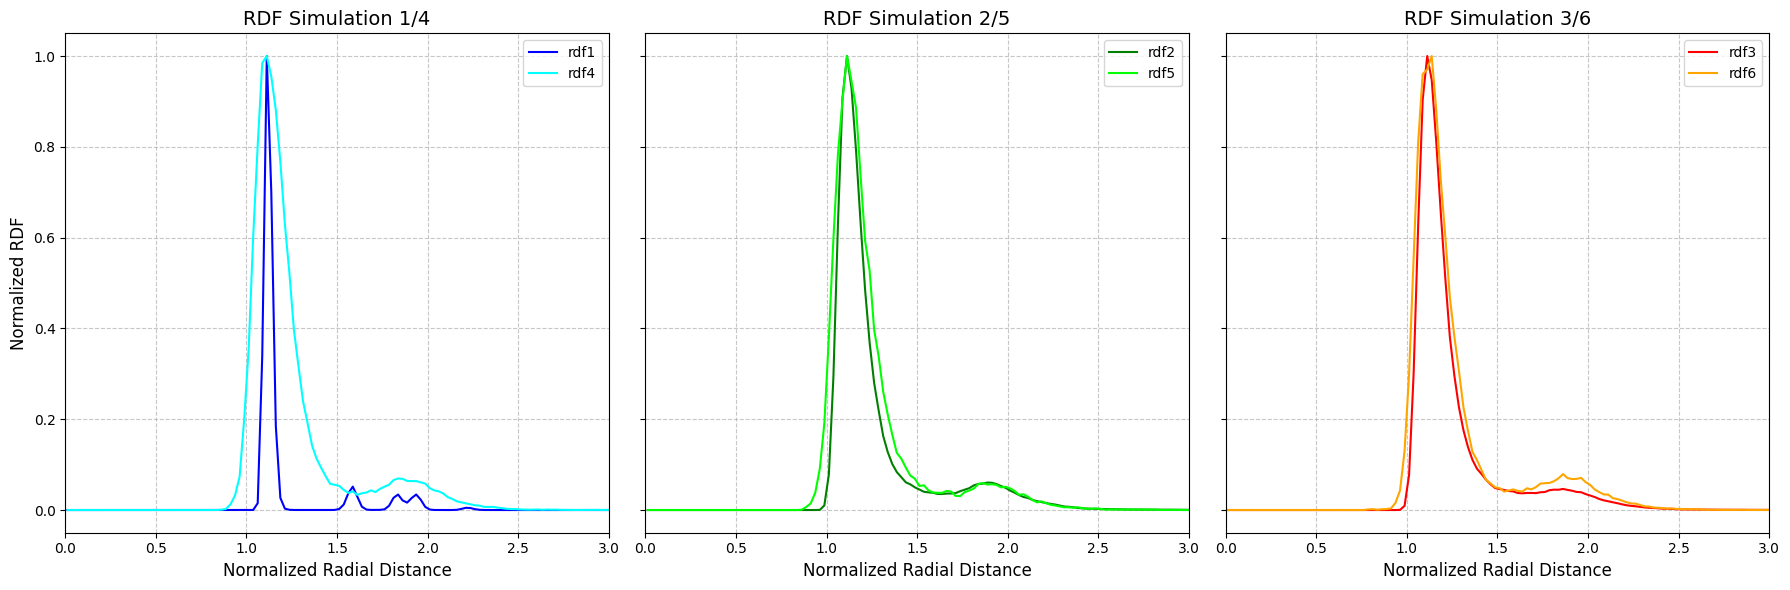

In [417]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot rdf1 and rdf4 on the first subplot
axes[0].plot(rdf1[0], rdf1[1] / rdf1[1].max(), label='rdf1', color='blue')
axes[0].plot(rdf4[0], rdf4[1] / rdf4[1].max(), label='rdf4', color='cyan')
axes[0].set_title('RDF Simulation 1/4', fontsize=14)
axes[0].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[0].set_ylabel('Normalized RDF', fontsize=12)
axes[0].legend()

# Plot rdf2 and rdf5 on the second subplot
axes[1].plot(rdf2[0], rdf2[1] / rdf2[1].max(), label='rdf2', color='green')
axes[1].plot(rdf5[0], rdf5[1] / rdf5[1].max(), label='rdf5', color='lime')
axes[1].set_title('RDF Simulation 2/5', fontsize=14)
axes[1].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[1].legend()

# Plot rdf3 and rdf6 on the third subplot
axes[2].plot(rdf3[0], rdf3[1] / rdf3[1].max(), label='rdf3', color='red')
axes[2].plot(rdf6[0], rdf6[1] / rdf6[1].max(), label='rdf6', color='orange')
axes[2].set_title('RDF Simulation 3/6', fontsize=14)
axes[2].set_xlabel('Normalized Radial Distance', fontsize=12)
axes[2].legend()

# Set consistent x-limits and grid lines
for ax in axes:
    ax.set_xlim(0, 3)
    ax.grid(linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()



These aren't terrible, though the bumps in simulation 1 really aren't captured at all. I suspect a model that trained better would be able to give reasonable results for the low temperature system, despite not having seen this training data, though it's hard to infer confidently without actually trying it. 